# Credit Risk Modelling: Project
Antoni Ballaun, Laura Hoang, Jędrzej Joniec, Piotr Zambrzycki

## 04. Models: XGBOOST

##### Preparing data, will try two approaches
1. Encode categorical features as dummy variables
2. Try to instead use target-statistic base encoding as it has been shown to achieve better results on certain datasets.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

In [2]:
X_train = pd.read_csv("X_train_standard.csv")
X_test  = pd.read_csv("X_test_standard.csv")

y_train = pd.read_csv("y_train.csv")
y_test  = pd.read_csv("y_test.csv")


In [3]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91844 entries, 0 to 91843
Data columns (total 33 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   DelinquenciesLast7Years             91844 non-null  float64
 1   CurrentlyInGroup                    91844 non-null  int64  
 2   EmploymentStatus                    91844 non-null  object 
 3   Term                                91844 non-null  int64  
 4   EmploymentStatusDuration            91844 non-null  float64
 5   BankcardUtilization                 91844 non-null  float64
 6   IncomeRange                         91844 non-null  object 
 7   TotalTrades                         91844 non-null  float64
 8   InquiriesLast6Months                91844 non-null  float64
 9   AmountDelinquent                    91844 non-null  float64
 10  StatedMonthlyIncome                 91844 non-null  float64
 11  CurrentDelinquencies                91844

In [ ]:
X_combined = pd.concat([X_train, X_test], axis=0)

X_combined_dummies = pd.get_dummies(X_combined, drop_first=True)

X_train_dummies = X_combined_dummies.iloc[:len(X_train), :]
X_test_dummies = X_combined_dummies.iloc[len(X_train):, :]
X_test_dummies = X_test_dummies.reindex(columns=X_train_dummies.columns, fill_value=0) # if same categories are not in test just in case

In [5]:
for col in X_train.select_dtypes(include='object').columns:
    categories = sorted(X_combined[col].dropna().unique())
    reference = categories[0]  # This is the dropped one
    print(f" '{col}': {reference}")

 'EmploymentStatus': Employed
 'IncomeRange': $0
 'BorrowerState': AK


### Now both sets will be fitted to a basic xgboost algorithm, to see which works better for this data

In [6]:
import xgboost as xgb
from xgboost import XGBClassifier
print(xgb.__version__) # This is a check if the version is > 1.3 as before that you had to pass encoded cartegoricals

3.0.0


In [7]:
model_dummies = XGBClassifier()
model_dummies.fit(X_train_dummies, y_train)


y_pred_dummies = model_dummies.predict(X_test_dummies)

In [8]:

for col in X_train.select_dtypes(include='object').columns:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')


dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)


params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'tree_method': 'hist'  # required for categorical 
}

model_native = xgb.train(params, dtrain, num_boost_round=100)
y_pred_native = model_native.predict(dtest)

In [9]:
y_pred_native_proba = model_native.predict(dtest)
y_pred_native = (y_pred_native_proba > 0.5).astype(int)

y_pred_dummies_proba = model_dummies.predict_proba(X_test_dummies)[:, 1]
y_pred_dummies = model_dummies.predict(X_test_dummies)

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report, confusion_matrix


acc_native = accuracy_score(y_test, y_pred_native)
prec_native = precision_score(y_test, y_pred_native)
rec_native = recall_score(y_test, y_pred_native)
f1_native = f1_score(y_test, y_pred_native)
auc_native = roc_auc_score(y_test, y_pred_native_proba)


acc_dummies = accuracy_score(y_test, y_pred_dummies)
prec_dummies = precision_score(y_test, y_pred_dummies)
rec_dummies = recall_score(y_test, y_pred_dummies)
f1_dummies = f1_score(y_test, y_pred_dummies)
auc_dummies = roc_auc_score(y_test, y_pred_dummies_proba)


print("Dummy used")
print(f"Accuracy : {acc_dummies:.4f}")
print(f"Precision: {prec_dummies:.4f}")
print(f"Recall   : {rec_dummies:.4f}")
print(f"F1 Score : {f1_dummies:.4f}")
print(f"AUC      : {auc_dummies:.4f}")

print("\nNo dummies")
print(f"Accuracy : {acc_native:.4f}")
print(f"Precision: {prec_native:.4f}")
print(f"Recall   : {rec_native:.4f}")
print(f"F1 Score : {f1_native:.4f}")
print(f"AUC      : {auc_native:.4f}")

Dummy used
Accuracy : 0.8653
Precision: 0.5951
Recall   : 0.2893
F1 Score : 0.3893
AUC      : 0.8550

No dummies
Accuracy : 0.8645
Precision: 0.5830
Recall   : 0.3052
F1 Score : 0.4006
AUC      : 0.8496


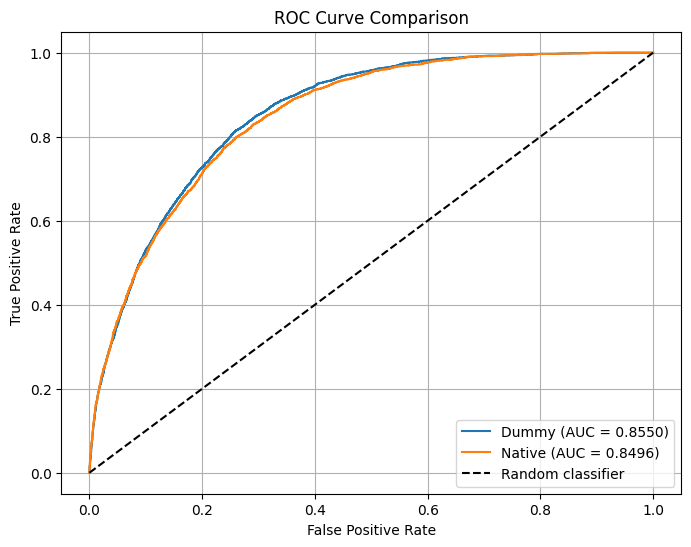

In [11]:

fpr_dummies, tpr_dummies, _ = roc_curve(y_test, y_pred_dummies_proba)
fpr_native, tpr_native, _ = roc_curve(y_test, y_pred_native_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_dummies, tpr_dummies, label=f"Dummy (AUC = {auc_dummies:.4f})")
plt.plot(fpr_native, tpr_native, label=f"Native (AUC = {auc_native:.4f})")
plt.plot([0, 1], [0, 1], "k--", label="Random classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()

### Both approaches gave almost identical results so I will use dummy encoded variables as they are slightly easier to interpret. Before running a Grid Search I will also compare
1. Inputing data with handling imbalance
2. Using class weights for imbalance
3. Using SMOTE

In [12]:
# This will be a simple function to make the process faster
def evaluate_model(model, X_train, y_train, X_test, y_test, description=""):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"\n{description}")
    print(classification_report(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("AUC     :", roc_auc_score(y_test, y_proba))

In [13]:
y_train = np.ravel(y_train).astype(int)  

# Class weight based on proportions of good and bad
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos

In [14]:
baseline_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
evaluate_model(baseline_model, X_train_dummies, y_train, X_test_dummies, y_test, "Baseline")


Baseline
              precision    recall  f1-score   support

           0       0.89      0.97      0.92     19553
           1       0.60      0.29      0.39      3408

    accuracy                           0.87     22961
   macro avg       0.74      0.63      0.66     22961
weighted avg       0.84      0.87      0.84     22961

F1 Score: 0.3893385982230997
AUC     : 0.8550464756437841


In [15]:
weighted_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight)
evaluate_model(weighted_model, X_train_dummies, y_train, X_test_dummies, y_test, f"With class weighting (scale_pos_weight={scale_pos_weight:.2f})")


With class weighting (scale_pos_weight=5.76)
              precision    recall  f1-score   support

           0       0.95      0.78      0.86     19553
           1       0.37      0.74      0.50      3408

    accuracy                           0.78     22961
   macro avg       0.66      0.76      0.68     22961
weighted avg       0.86      0.78      0.80     22961

F1 Score: 0.4956308296514482
AUC     : 0.8494141449902984


In [16]:
smote = SMOTE(random_state=101)
X_train_smote, y_train_smote = smote.fit_resample(X_train_dummies, y_train)

smote_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
evaluate_model(smote_model, X_train_smote, y_train_smote, X_test_dummies, y_test, "With SMOTE oversampling")


With SMOTE oversampling
              precision    recall  f1-score   support

           0       0.89      0.96      0.92     19553
           1       0.56      0.32      0.41      3408

    accuracy                           0.86     22961
   macro avg       0.72      0.64      0.66     22961
weighted avg       0.84      0.86      0.84     22961

F1 Score: 0.4054559043348281
AUC     : 0.8472343226751703


##### Comparing these 3 results class weights look like the best approach as they gave by far the best TPR, while also maintaing a good enough false positve rate (36 out of 100 flagged will be actually defaulted) and also all 3 models had almost the same AUC.

### Now that we have chosen the approach to categorical encoding handling as well as class imbalance we can setup a grid search to fine tune the model

In [17]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer

param_grid_test = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5]
}
# This will by 729 confings * 3 folds so around 2200 runs. 

xgb_test = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    verbosity=1
)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=101)

grid_search_test = GridSearchCV(
    estimator=xgb_test,
    param_grid=param_grid_test,
    scoring='roc_auc',
    n_jobs=-1,
    cv=cv,
    verbose=2
)

grid_search_test.fit(X_train_dummies, y_train)

print("Grid Search - Best Params:", grid_search_test.best_params_)
print("Grid Search - Best AUC:", grid_search_test.best_score_)

Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Grid Search - Best Params: {'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.8}
Grid Search - Best AUC: 0.8639753590431676


In [18]:
# Best params from GridSearchCV
best_params = {
    'colsample_bytree': 0.6,
    'gamma': 1,
    'learning_rate': 0.05,
    'max_depth': 5,
    'n_estimators': 500,
    'subsample': 1.0
}


final_model = XGBClassifier(
    **best_params,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    verbosity=1
)

final_model.fit(X_train_dummies, y_train)

y_pred_proba = final_model.predict_proba(X_test_dummies)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("AUC on test:", roc_auc)

AUC on test: 0.8572493333395762


##### After fine tunnig AUC on test data went up by around 1%.

AUC: 0.8572


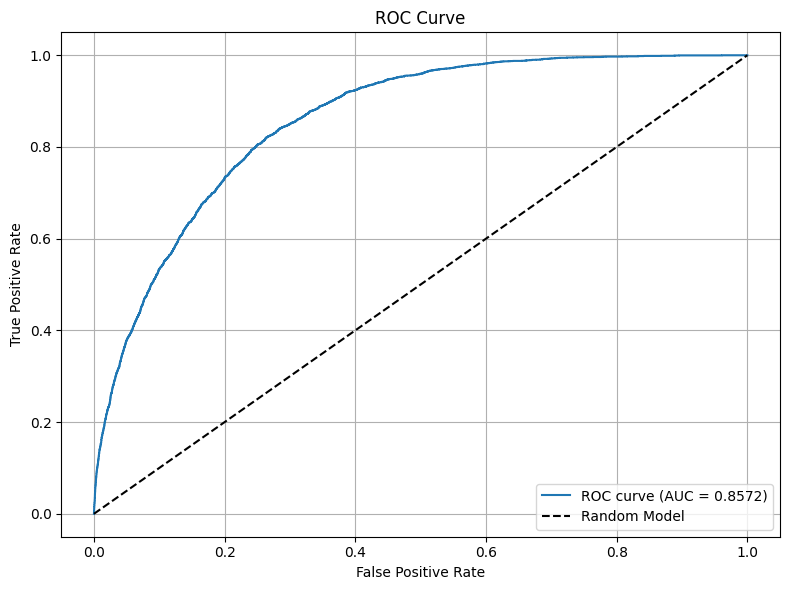

In [20]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

print(f"AUC: {roc_auc:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

### Tunning the prediction treshold

In [21]:
y_pred = final_model.predict(X_test_dummies)

roc_auc = roc_auc_score(y_test, y_pred_proba)
print("AUC on test:", roc_auc)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

AUC on test: 0.8572493333395762

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.76      0.85     19553
           1       0.36      0.79      0.50      3408

    accuracy                           0.76     22961
   macro avg       0.66      0.78      0.67     22961
weighted avg       0.87      0.76      0.79     22961


Confusion Matrix:
[[14852  4701]
 [  714  2694]]


##### Since not predicting that someone will default is much more costly than the other way around, we should try lowering the threshold to get a higher recall and especially TPR even at the cost of getting more FN.

In [ ]:
y_pred_proba = final_model.predict_proba(X_test_dummies)[:, 1]

thresholds = [0.25,0.3,0.35, 0.4, 0.45]

for threshold in thresholds:
    print(f"\n=== Threshold: {threshold} ===")
    
    y_pred_thresh = (y_pred_proba >= threshold).astype(int)
    
    print("Classification Report:")
    print(classification_report(y_test, y_pred_thresh))
    
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred_thresh))


=== Threshold: 0.25 ===
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.56      0.71     19553
           1       0.27      0.94      0.42      3408

    accuracy                           0.61     22961
   macro avg       0.63      0.75      0.57     22961
weighted avg       0.88      0.61      0.67     22961

Confusion Matrix:
[[10869  8684]
 [  193  3215]]

=== Threshold: 0.3 ===
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.60      0.75     19553
           1       0.29      0.92      0.44      3408

    accuracy                           0.65     22961
   macro avg       0.63      0.76      0.59     22961
weighted avg       0.88      0.65      0.70     22961

Confusion Matrix:
[[11773  7780]
 [  263  3145]]

=== Threshold: 0.35 ===
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.64      0.78     19

This is not a simple choice as too many FP are also bad for buisness as the bank starts to lose market share, so take that into consideration as well I belive the 0.4 treshold is optimal. This means that 6319(32% of good clients) are not going to get a credit even thought they would not default, however of those who will be given a credit only 454(13% of actual defaulters will still recive a loan) will go into default.

### Final metrics to compare between models and for simulating profits

In [23]:
gini = 2 * roc_auc - 1
y_pred_proba = final_model.predict_proba(X_test_dummies)[:, 1]
y_pred_thresh = (y_pred_proba >= 0.45).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred_thresh))    

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_thresh))

print()

print(f"AUC: {roc_auc:.2f}")
print(f"Gini: {gini:.2f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.72      0.83     19553
           1       0.34      0.83      0.49      3408

    accuracy                           0.74     22961
   macro avg       0.65      0.78      0.66     22961
weighted avg       0.87      0.74      0.78     22961

Confusion Matrix:
[[14148  5405]
 [  577  2831]]

AUC: 0.86
Gini: 0.71


In [24]:
final_model.save_model("XGboost.json")

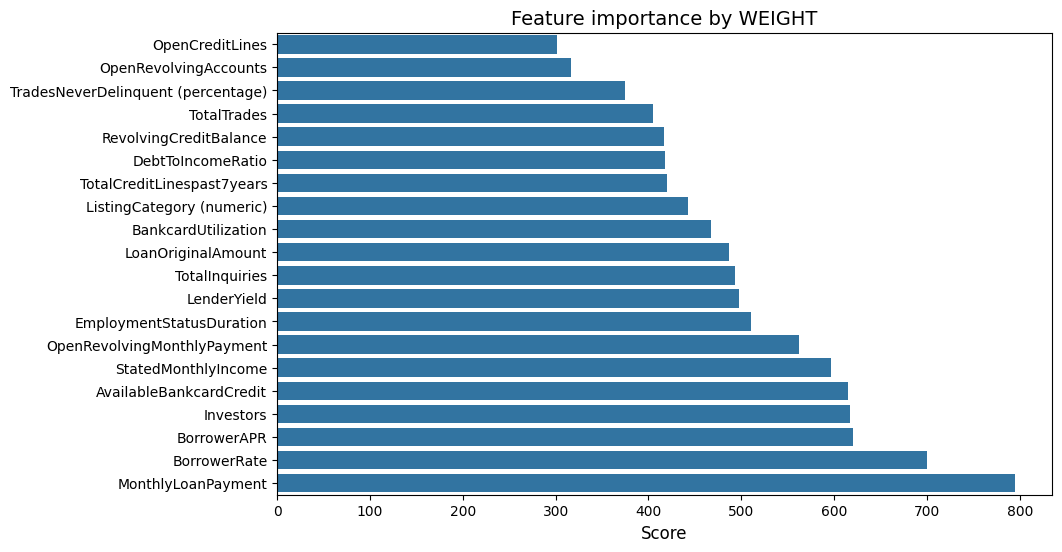

In [59]:
# Feature importance by `weight` - number of times the feature was used in decision-making

fi_weight = final_model.get_booster().get_score(importance_type='weight')
fi_weight_df = pd.DataFrame(data={"column": list(fi_weight.keys()), "score": list(fi_weight.values())})
fi_weight_df = fi_weight_df.nlargest(20, columns="score").sort_values(by = "score", ascending=True)

plt.figure(figsize=(10, 6))
sns.barplot(data=fi_weight_df, x='score', y='column')
plt.title('Feature importance by WEIGHT', fontsize=14)
plt.axvline(0, color='k', linestyle='--', alpha=0.3)
plt.xlabel('Score', fontsize=12)
plt.ylabel(None)
plt.show()

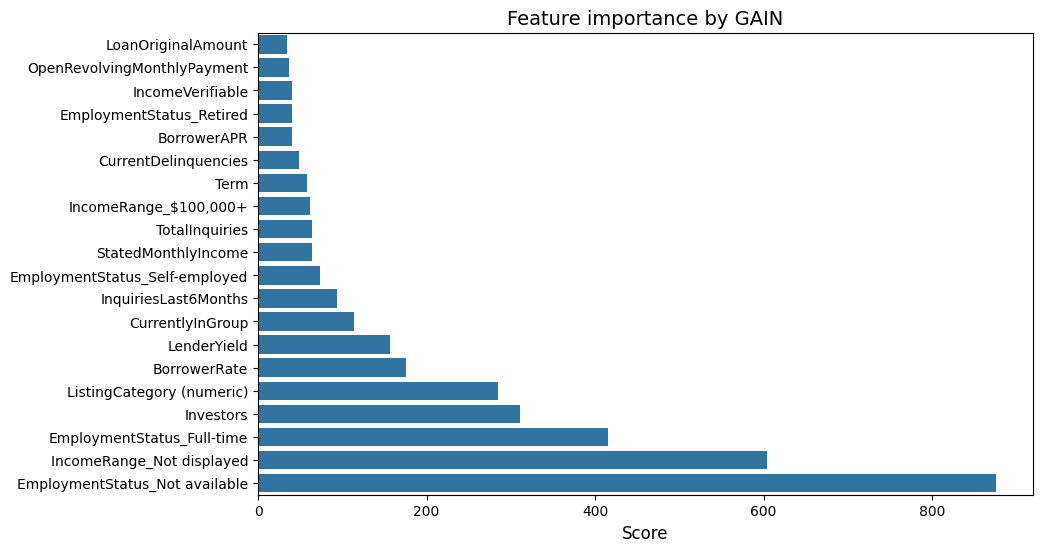

In [60]:
# Feature importance by `gain` - average information gain

fi_weight = final_model.get_booster().get_score(importance_type='gain')
fi_weight_df = pd.DataFrame(data={"column": list(fi_weight.keys()), "score": list(fi_weight.values())})
fi_weight_df = fi_weight_df.nlargest(20, columns="score").sort_values(by = "score", ascending=True)

plt.figure(figsize=(10, 6))
sns.barplot(data=fi_weight_df, x='score', y='column')
plt.title('Feature importance by GAIN', fontsize=14)
plt.axvline(0, color='k', linestyle='--', alpha=0.3)
plt.xlabel('Score', fontsize=12)
plt.ylabel(None)
plt.show()